In [1]:
from isc_standalone import (isc, isfc,
                            compute_summary_statistic, load_images,squareform_isfc,
                            load_boolean_mask, mask_images,
                            MaskedMultiSubjectData) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, zscore
from scipy.spatial.distance import squareform
import nibabel as nib

### The "Pieman" data 
For this script we will use the "Pieman" dataset from Simony et al. (2016). A description of the dataset is as follows:

18 native English speakers were scanned (15 females, ages: 18–31), corresponding to the replication dataset from the Pieman study.
Stimuli for the experiment were generated from a 7 min real life story ("Pie Man", Jim O'Grady) recorded at a live storytelling performance ("The Moth" storytelling event, New York City). Subjects listened to the story from beginning to end (intact condition). In addition, subjects listened to scrambled versions of the story, which were generated by dividing the original stimulus into segments of different timescales (paragraphs and words) and then permuting the order of these segments. To generate the scrambled stimuli, the story was segmented manually by identifying the end points of each word and paragraph. Two adjacent short words were assigned to a single segment in cases where we could not separate them. Following segmentation, the intact story was scrambled at two timescales: short—‘words’ (W; 608 words, 0.7±0.5 s each) and long—‘paragraphs’ (P; 11 paragraphs, 38.1±17.6 s each). Laughter and applause were classified as single word events (4.4% of the words). Twelve seconds of neutral music and 3 s of silence preceded, and 15 s of silence followed, each playback in all conditions. These music and silence periods were discarded from all analyses.

More details about the experiment may be accessed in the methods section of the paper.

In [22]:
from isc_standalone import (isc, isfc,
                            compute_summary_statistic, load_images,squareform_isfc,
                            load_boolean_mask, mask_images,
                            MaskedMultiSubjectData) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, zscore
from scipy.spatial.distance import squareform
import nibabel as nib
import os 
from scipy.cluster.hierarchy import fcluster, linkage
from nilearn import plotting

In [11]:
# Set up experiment metadata

pieman2_dir = r'C:\Users\eyalh\Documents\fmri with ML\data\Pieman2'
output_path = r'C:\Users\eyalh\Documents\fmri with ML\data\output'

dir_mask = os.path.join(pieman2_dir, 'masks/')
mask_name = os.path.join(dir_mask, 'avg152T1_gray_3mm.nii.gz')
all_task_names = ['word', 'intact1']
all_task_des = ['word level scramble', 'intact story']
n_subjs_total = 18
group_assignment_dict = {task_name: i for i, task_name in enumerate(all_task_names)}

# Where do you want to store the data
dir_out = output_path
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print('Dir %s created ' % dir_out)

In [17]:
upper_limit_n_subjs = 5

def get_file_names(data_dir_, task_name_, verbose = False):
    """
    Get all the participant file names
    
    Parameters
    ----------
    data_dir_ [str]: the data root dir
    task_name_ [str]: the name of the task 
    
    Return
    ----------
    fnames_ [list]: file names for all subjs
    """
    c_ = 0 
    fnames_ = []
    # Collect all file names 
    for subj in range(1, n_subjs_total): 
        fname = os.path.join(
            data_dir_, 'sub-%.3d/func/sub-%.3d-task-%s.nii.gz' % (subj, subj, task_name_))
        
        # If the file exists
        if os.path.exists(fname):
            
            # Add to the list of file names 
            fnames_.append(fname)
            if verbose: 
                print(fname)
            c_+= 1
            if c_ >= upper_limit_n_subjs: 
                break
    return fnames_

In [18]:
# Load the brain mask
brain_mask = load_boolean_mask(mask_name)

# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

# Load the brain nii image
brain_nii = nib.load(mask_name)

In [19]:
"""load bold data"""

# load the functional data 
fnames = {}
images = {}
masked_images = {}
bold = {}
group_assignment = []
n_subjs = {}

for task_name in all_task_names: 
    fnames[task_name] = get_file_names(pieman2_dir, task_name)
    images[task_name] = load_images(fnames[task_name]) 
    masked_images[task_name] = mask_images(images[task_name], brain_mask) 
    # Concatenate all of the masked images across participants  
    bold[task_name] = MaskedMultiSubjectData.from_masked_images(
        masked_images[task_name], len(fnames[task_name])
    )
    # Convert nans into zeros
    bold[task_name][np.isnan(bold[task_name])] = 0
    # compute the group assignment label 
    n_subjs_this_task = np.shape(bold[task_name])[-1]
    group_assignment += list(
        np.repeat(group_assignment_dict[task_name], n_subjs_this_task)
    )
    n_subjs[task_name] = np.shape(bold[task_name])[-1]
    print('Data loaded: {} \t shape: {}' .format(task_name, np.shape(bold[task_name])))

Data loaded: word 	 shape: (300, 98508, 5)
Data loaded: intact1 	 shape: (300, 98508, 5)


2.3 Compute ISC 
ISC is the correlation of each voxel's time series for a participant with the corresponding (anatomically aligned) voxel time series in the average of the other participants' brains. BrainIAK has functions for computing ISC by feeding in the concatenated participant data.

This will take about 10 minutes to complete.

In [20]:
# run ISC, loop over conditions 
isc_maps = {}
for task_name in all_task_names:
    isc_maps[task_name] = isc(bold[task_name], pairwise=False)
    print('Shape of %s condition:' % task_name, np.shape(isc_maps[task_name]))

Shape of word condition: (5, 98508)
Shape of intact1 condition: (5, 98508)


The output of ISC is a voxel by participant matrix (showing the result of each individual with the group). Below we will visualize the ISC matrix for one participant and condition back on to the brain to see where activity is correlated between participants.

In [24]:
# set params 
subj_id = 0
task_name = 'word'
save_data = False

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_maps[task_name][subj_id, :]
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Save the ISC data as a volume
if save_data: 
    isc_map_path = os.path.join(dir_out, 'ISC_%s_sub%.2d.nii.gz' % (task_name, subj_id))
    nib.save(isc_nifti, isc_map_path)

Text(0.5, 1.0, 'ISC map for subject 0, task = word')

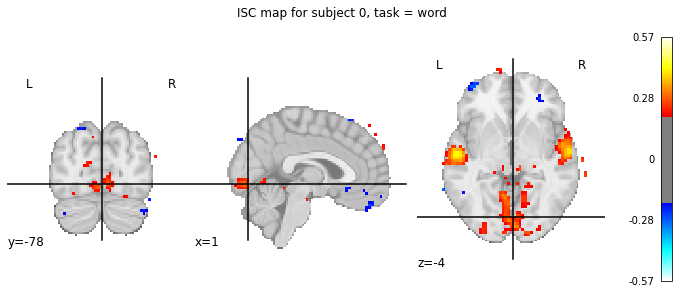

In [25]:
# Plot the data as a statmap
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax
)
ax.set_title('ISC map for subject {}, task = {}' .format(subj_id,task_name)) 

## ISFC 
The goal of ISFC is to find coupling between brain regions across participants. For example the angular gyrus in subject 1 could be correlated to the pre-frontal cortex in subject 2, if they share some cognitive state. For completely random cognitive states across these two subjects, the correlation should be zero. ISFC helps us identify such commonalities across subjects.

In this section, we will compare functional connectivity vs. ISFC on the Pieman data. Whereas FC is computed within individuals, ISFC is computed between individuals. Hence the only correlations that should be robust in ISFC are those that are present across individuals. At the end of the exercises, you will qualitatively replicate Simony et al. (2016), showing that ISFC is sensitive to the cognitive state of the participants.

In [27]:
from nilearn import datasets


Dataset created in C:\Users\eyalh/nilearn_data\fsl



Downloaded 25133056 of 25716861 bytes (97.7%,    0.8s remaining) ...done. (39 seconds, 0 min)
Extracting data from C:\Users\eyalh/nilearn_data\fsl\5ee0c916f7b52e5bd452166f59df1b37\HarvardOxford.tgz..... done.


number of voxels:	 (98508, 5)
number of parcels:	 96


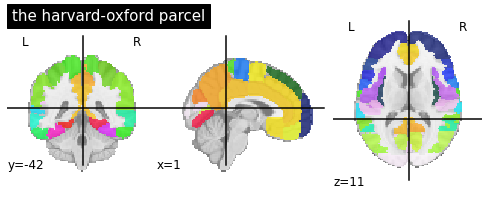

In [28]:
# load a parcel
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split=True)
plotting.plot_roi(atlas.maps, title='the harvard-oxford parcel')

n_regions = len(atlas.labels)-1 # rm background region 
n_TRs = np.shape(bold[task_name])[0]

print('number of voxels:\t {}'.format(np.shape(bold[task_name][1])))
print('number of parcels:\t {}'.format(n_regions))

In [30]:
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker


c:\Users\eyalh\AppData\Local\Continuum\anaconda3\envs\fmri-HIT\lib\site-packages\nilearn\input_data\__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [31]:
# Get a masker for the atlas 
masker_ho = NiftiLabelsMasker(labels_img=atlas.maps)

# Transform the data to the parcel space
bold_ho = {
    task_name:np.zeros((n_TRs, n_regions, n_subjs[task_name])) 
    for task_name in all_task_names}

# Collect all data 
row_has_nan = np.zeros(shape=(n_regions,), dtype=bool)
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        
        # get the data for task t, subject s 
        nii_t_s = nib.load(fnames[task_name][subj_id])
        bold_ho[task_name][:,:,subj_id] = masker_ho.fit_transform(nii_t_s)
        
        # figure out missing rois
        row_has_nan_ = np.any(np.isnan(bold_ho[task_name][:,:,subj_id]),axis=0)
        row_has_nan[row_has_nan_] = True                

# Figure out which ROI has missing values
roi_select = np.logical_not(row_has_nan)
n_roi_select = np.sum(roi_select)
rois_filtered = np.array(atlas.labels[1:])[roi_select]
bold_ho_filtered = {
    task_name:np.zeros((n_TRs, n_roi_select, n_subjs[task_name])) 
    for task_name in all_task_names
}

# Remove ROIs with missing values
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        bold_ho_filtered[task_name][:,:,subj_id] = bold_ho[task_name][:,roi_select,subj_id]
              
print('ROI selected\n {}'.format(rois_filtered))
print('ROI removed due to missing values :( \n {}'.format(np.array(atlas.labels[1:])[row_has_nan]))

c:\Users\eyalh\AppData\Local\Continuum\anaconda3\envs\fmri-HIT\lib\site-packages\nilearn\_utils\niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


ROI selected
 ['Left Frontal Pole' 'Right Frontal Pole' 'Left Insular Cortex'
 'Right Insular Cortex' 'Left Superior Frontal Gyrus'
 'Right Superior Frontal Gyrus' 'Left Middle Frontal Gyrus'
 'Right Middle Frontal Gyrus'
 'Left Inferior Frontal Gyrus, pars triangularis'
 'Right Inferior Frontal Gyrus, pars triangularis'
 'Left Inferior Frontal Gyrus, pars opercularis'
 'Right Inferior Frontal Gyrus, pars opercularis' 'Left Precentral Gyrus'
 'Right Precentral Gyrus' 'Left Temporal Pole' 'Right Temporal Pole'
 'Left Superior Temporal Gyrus, anterior division'
 'Right Superior Temporal Gyrus, anterior division'
 'Left Superior Temporal Gyrus, posterior division'
 'Right Superior Temporal Gyrus, posterior division'
 'Left Middle Temporal Gyrus, anterior division'
 'Right Middle Temporal Gyrus, anterior division'
 'Left Middle Temporal Gyrus, posterior division'
 'Right Middle Temporal Gyrus, posterior division'
 'Left Middle Temporal Gyrus, temporooccipital part'
 'Right Middle Temporal 

In [32]:
# Compute ISFC
isfc_maps_ho = {}
for task_name in all_task_names:
    isfc_maps_ho[task_name] = isfc(data=bold_ho_filtered[task_name],
                                   summary_statistic='median',
                                   vectorize_isfcs=False)   

TypeError: object of type 'int' has no len()

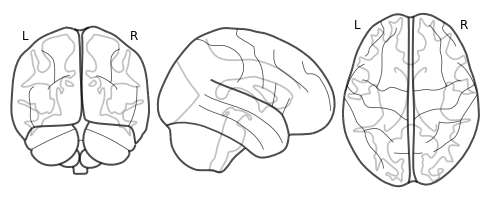

In [51]:
plotting.plot_connectome(isfc_maps_ho['word'], n_regions)

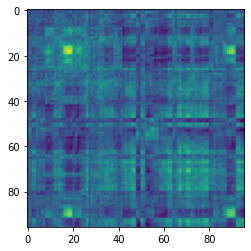

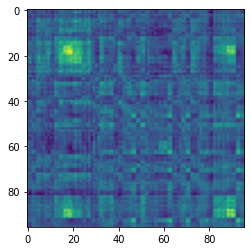

In [46]:
# set params 
plt.figure()
plt.imshow(isfc_maps_ho['word'])
plt.figure()
plt.imshow(isfc_maps_ho['intact1'])
plt.show()